In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

In [0]:
from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import Model
from keras.backend import reverse

In [0]:
max_words = 30000
max_words_length = 400
embedding_dimension = 300

lstm_options = {
    'units': 128,
    'dropout': 0.2,
    'return_sequences': True
}

convolution_options = {
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 300,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'valid',
    'activation': 'tanh',
    'dilation_rate': 1,
    'should_preactivate': True
}

In [0]:
def forward_lstm(comment_embedding):
    lstm = CuDNNLSTM(
        units=lstm_options['units'], 
        return_sequences=lstm_options['return_sequences']
    )(comment_embedding)
    lstm = Dropout(lstm_options['dropout'])(lstm)
    
    return lstm

def backward_lstm(comment_embedding):
    reversed_embeddings = Lambda(lambda x: reverse(x, axes=1))(comment_embedding)
    lstm = CuDNNLSTM(
        units=lstm_options['units'], 
        return_sequences=lstm_options['return_sequences']
    )(reversed_embeddings)   
    lstm = Dropout(lstm_options['dropout'])(lstm)

    return Lambda(lambda x: reverse(x, axes=1))(lstm)

In [0]:
from keras.optimizers import *
from keras.initializers import *
from keras.layers import *
from keras.layers.merge import *
from keras.models import *

residual_convolution_options = dict({
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 128,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'same',
    'activation': 'elu',
    'dilation_rate': 1,
    'should_preactivate': True
})

scaled_residual_convolution_options=residual_convolution_options
scaled_residual_convolution_options['activation']='tanh'

def convolution_block(input_layer, options):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    convolution_block = convolution_input

    if(options['should_preactivate']):
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   dilation_rate=options['dilation_rate'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
    else:
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   dilation_rate=options['dilation_rate'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)

    convolution_output = convolution_block

    if(options['dropout_mode'] == 'spatial'):
        convolution_output = SpatialDropout1D(options['dropout_rate'])(convolution_output)
    if(options['dropout_mode']== 'vanilla'):
        convolution_output = Dropout(options['dropout_rate'])(convolution_output)

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def residual_add_block(input_layer, should_pool, dilation_rate=1):
    residual_convolution_options['dilation_rate'] = dilation_rate
    
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = add([
        residual_block_pool,
        convolution_block(residual_block_pool, residual_convolution_options)
    ])
    residual_block = add([
        residual_block,
        convolution_block(residual_block, residual_convolution_options)
    ])
    
    convolution_output = add([residual_block, residual_block_pool])

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def classification_block(input_layer, dropout_rate=0.2):
    model = Dense(256, activation='linear', kernel_initializer='he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    model = Dense(256, activation='linear', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    return Dense(6, activation='sigmoid', kernel_initializer='glorot_normal')(model)

In [15]:
input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('custom_fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

context = concatenate([
    forward_lstm(averaged_embedding_layer),
    averaged_embedding_layer,
    backward_lstm(averaged_embedding_layer)
])
context = Dropout(0.2)(context)

scaled_context = convolution_block(context, scaled_residual_convolution_options)

resnet = residual_add_block(scaled_context, should_pool = False, dilation_rate=1)
resnet = residual_add_block(resnet, should_pool = True, dilation_rate=1)
resnet = residual_add_block(resnet, should_pool = True, dilation_rate=1)
resnet = residual_add_block(resnet, should_pool = True, dilation_rate=1)

lstm_pooled_features = concatenate([
    yoon_kim_feature_extractor(scaled_context, convolution_options['filters']),
    GlobalMaxPooling1D()(scaled_context),
    GlobalAveragePooling1D()(scaled_context)
])

resnet_pooled_features = yoon_kim_feature_extractor(scaled_context, convolution_options['filters'])

pooled_features = concatenate([
    lstm_pooled_features,
    resnet_pooled_features
])

output_layer = classification_block(pooled_features, dropout_rate=0.2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [16]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 12:35 - loss: 0.1144 - acc: 0.9610

102112/102124 [============================>.] - ETA: 0s - loss: 0.0728 - acc: 0.9746

102124/102124 [==============================] - 1005s 10ms/step - loss: 0.0728 - acc: 0.9746 - val_loss: 0.0662 - val_acc: 0.9737
Epoch 2/32
 10080/102124 [=>............................] - ETA: 14:06 - loss: 0.0550 - acc: 0.9803

102112/102124 [============================>.] - ETA: 0s - loss: 0.0539 - acc: 0.9803

102124/102124 [==============================] - 1006s 10ms/step - loss: 0.0539 - acc: 0.9803 - val_loss: 0.0462 - val_acc: 0.9821
roc-auc: 0.9801 - roc-auc_val: 0.9771                                                                                                    
Epoch 3/32
  8640/102124 [=>............................] - ETA: 14:16 - loss: 0.0515 - acc: 0.9806

102112/102124 [============================>.] - ETA: 0s - loss: 0.0497 - acc: 0.9815

102124/102124 [==============================] - 1005s 10ms/step - loss: 0.0497 - acc: 0.9815 - val_loss: 0.0474 - val_acc: 0.9815
Epoch 4/32
 10080/102124 [=>............................] - ETA: 14:04 - loss: 0.0502 - acc: 0.9814

102112/102124 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9821

102124/102124 [==============================] - 1005s 10ms/step - loss: 0.0476 - acc: 0.9821 - val_loss: 0.0452 - val_acc: 0.9830
roc-auc: 0.9858 - roc-auc_val: 0.9816                                                                                                    
Epoch 5/32
  8640/102124 [=>............................] - ETA: 14:16 - loss: 0.0459 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9826

102124/102124 [==============================] - 1004s 10ms/step - loss: 0.0454 - acc: 0.9826 - val_loss: 0.0428 - val_acc: 0.9837
Epoch 6/32
 10080/102124 [=>............................] - ETA: 14:02 - loss: 0.0433 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0445 - acc: 0.9831

102124/102124 [==============================] - 1004s 10ms/step - loss: 0.0445 - acc: 0.9831 - val_loss: 0.0433 - val_acc: 0.9832
roc-auc: 0.9895 - roc-auc_val: 0.9858                                                                                                    
Epoch 7/32
  8640/102124 [=>............................] - ETA: 14:15 - loss: 0.0441 - acc: 0.9829

102112/102124 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9833

102124/102124 [==============================] - 1003s 10ms/step - loss: 0.0430 - acc: 0.9833 - val_loss: 0.0417 - val_acc: 0.9838
Epoch 8/32
 10080/102124 [=>............................] - ETA: 14:03 - loss: 0.0438 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0418 - acc: 0.9837

102124/102124 [==============================] - 1004s 10ms/step - loss: 0.0418 - acc: 0.9837 - val_loss: 0.0429 - val_acc: 0.9829
roc-auc: 0.9915 - roc-auc_val: 0.9882                                                                                                    
Epoch 9/32
  8640/102124 [=>............................] - ETA: 14:17 - loss: 0.0387 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9839

102124/102124 [==============================] - 1004s 10ms/step - loss: 0.0407 - acc: 0.9839 - val_loss: 0.0414 - val_acc: 0.9836
Epoch 10/32
 10048/102124 [=>............................] - ETA: 13:57 - loss: 0.0395 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9842

102124/102124 [==============================] - 998s 10ms/step - loss: 0.0403 - acc: 0.9842 - val_loss: 0.0425 - val_acc: 0.9832
roc-auc: 0.9926 - roc-auc_val: 0.9881                                                                                                    
Epoch 11/32
  8640/102124 [=>............................] - ETA: 14:07 - loss: 0.0362 - acc: 0.9858

102112/102124 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9846

102124/102124 [==============================] - 1000s 10ms/step - loss: 0.0391 - acc: 0.9846 - val_loss: 0.0421 - val_acc: 0.9834

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00017677669529803097.
Epoch 12/32
  7936/102124 [=>............................] - ETA: 14:21 - loss: 0.0383 - acc: 0.9856

102112/102124 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9848

102124/102124 [==============================] - 1002s 10ms/step - loss: 0.0386 - acc: 0.9848 - val_loss: 0.0406 - val_acc: 0.9840
roc-auc: 0.9934 - roc-auc_val: 0.9886                                                                                                    
Epoch 13/32
  8608/102124 [=>............................] - ETA: 14:21 - loss: 0.0409 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9850

102124/102124 [==============================] - 1006s 10ms/step - loss: 0.0376 - acc: 0.9850 - val_loss: 0.0425 - val_acc: 0.9834
Epoch 14/32
 10048/102124 [=>............................] - ETA: 14:04 - loss: 0.0393 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9852

102124/102124 [==============================] - 1008s 10ms/step - loss: 0.0372 - acc: 0.9852 - val_loss: 0.0409 - val_acc: 0.9839
roc-auc: 0.994 - roc-auc_val: 0.9885                                                                                                    
Epoch 15/32
  8640/102124 [=>............................] - ETA: 14:21 - loss: 0.0353 - acc: 0.9861

102112/102124 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9855

102124/102124 [==============================] - 1010s 10ms/step - loss: 0.0366 - acc: 0.9855 - val_loss: 0.0405 - val_acc: 0.9841
Epoch 16/32
 10048/102124 [=>............................] - ETA: 14:05 - loss: 0.0373 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0361 - acc: 0.9857

102124/102124 [==============================] - 1009s 10ms/step - loss: 0.0361 - acc: 0.9857 - val_loss: 0.0417 - val_acc: 0.9840
roc-auc: 0.9945 - roc-auc_val: 0.9883                                                                                                    
Epoch 17/32
  8608/102124 [=>............................] - ETA: 14:16 - loss: 0.0385 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9859

102124/102124 [==============================] - 1008s 10ms/step - loss: 0.0355 - acc: 0.9859 - val_loss: 0.0426 - val_acc: 0.9840
Epoch 18/32
 10048/102124 [=>............................] - ETA: 14:04 - loss: 0.0349 - acc: 0.9862

102112/102124 [============================>.] - ETA: 0s - loss: 0.0351 - acc: 0.9859

102124/102124 [==============================] - 1009s 10ms/step - loss: 0.0351 - acc: 0.9859 - val_loss: 0.0411 - val_acc: 0.9841
roc-auc: 0.995 - roc-auc_val: 0.9884                                                                                                    
Epoch 19/32
  8640/102124 [=>............................] - ETA: 14:19 - loss: 0.0352 - acc: 0.9862

102112/102124 [============================>.] - ETA: 0s - loss: 0.0347 - acc: 0.9861

102124/102124 [==============================] - 1008s 10ms/step - loss: 0.0347 - acc: 0.9861 - val_loss: 0.0427 - val_acc: 0.9837
Epoch 20/32
 10048/102124 [=>............................] - ETA: 14:04 - loss: 0.0311 - acc: 0.9878

102112/102124 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9866

102124/102124 [==============================] - 1009s 10ms/step - loss: 0.0339 - acc: 0.9866 - val_loss: 0.0428 - val_acc: 0.9836
roc-auc: 0.9954 - roc-auc_val: 0.9881                                                                                                    
Epoch 21/32
  8608/102124 [=>............................] - ETA: 14:15 - loss: 0.0311 - acc: 0.9877

102112/102124 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9866

102124/102124 [==============================] - 1004s 10ms/step - loss: 0.0339 - acc: 0.9866 - val_loss: 0.0420 - val_acc: 0.9842
Epoch 22/32
 10048/102124 [=>............................] - ETA: 14:04 - loss: 0.0342 - acc: 0.9865

102112/102124 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9866

102124/102124 [==============================] - 1004s 10ms/step - loss: 0.0336 - acc: 0.9866 - val_loss: 0.0428 - val_acc: 0.9841

Epoch 00022: ReduceLROnPlateau reducing learning rate to 5.632815373246558e-05.
roc-auc: 0.9956 - roc-auc_val: 0.988                                                                                                    
Epoch 23/32
  5920/102124 [>.............................] - ETA: 14:37 - loss: 0.0320 - acc: 0.9876

102112/102124 [============================>.] - ETA: 0s - loss: 0.0331 - acc: 0.9868

102124/102124 [==============================] - 1001s 10ms/step - loss: 0.0331 - acc: 0.9868 - val_loss: 0.0427 - val_acc: 0.9839
Epoch 24/32
 10048/102124 [=>............................] - ETA: 13:52 - loss: 0.0321 - acc: 0.9871

102112/102124 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9868

102124/102124 [==============================] - 999s 10ms/step - loss: 0.0329 - acc: 0.9868 - val_loss: 0.0428 - val_acc: 0.9839
roc-auc: 0.9959 - roc-auc_val: 0.9879                                                                                                    
Epoch 25/32
  8640/102124 [=>............................] - ETA: 14:14 - loss: 0.0322 - acc: 0.9868

102112/102124 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9870

102124/102124 [==============================] - 1001s 10ms/step - loss: 0.0324 - acc: 0.9870 - val_loss: 0.0433 - val_acc: 0.9841


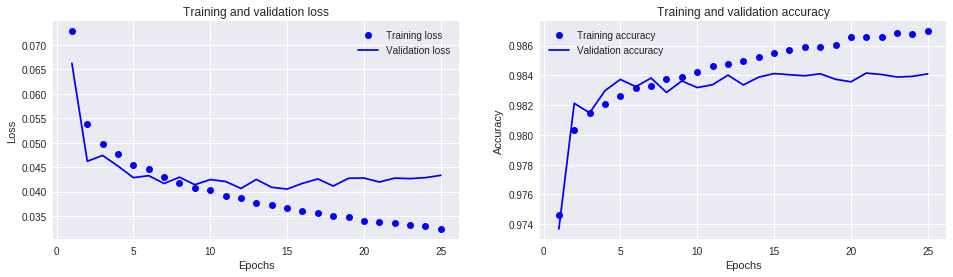

In [17]:
plot_history(history)

In [18]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 90s 3ms/step
([0.04195278402322767, 0.9844639276516918], 0.9901063669874194)
